In [1]:
"""""from interaction_matrices import interactions
from decay_matrices import decay_class
from rho_X import rho
import Lambdas
"""""

'""from interaction_matrices import interactions\nfrom decay_matrices import decay_class\nfrom rho_X import rho\nimport Lambdas\n'

In [2]:
import Lambdas
from differential_equation import Solver

In [3]:
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.sparse import *
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from jupyterthemes import jtplot


# MCEq Imports
from MCEq.particlemanager import ParticleManager
import MCEq.core 
from MCEq.core import MCEqRun
from MCEq.data import Decays
import mceq_config as config
#import primary model choices
import crflux.models as pm



config.muon_helicity_dependence=True

config.debug_level = 0

# Launcing mceq
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='SIBYLL23CPP',
    #primary cosmic ray flux model
    primary_model = (pm.HillasGaisser2012, "H3a"),
    
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
    
)



In [4]:
list_particles=[mceq_run.pman[2212],     #p+           (0)
                mceq_run.pman[-2212],     #pbar-        (1)
                mceq_run.pman[2112],     #n            (2)
                mceq_run.pman[-2112],    #nbar         (3)
                mceq_run.pman[211],      #pi+          (4)
                mceq_run.pman[-211],     #pi-          (5)
                mceq_run.pman[310],      #K_S0         (6) 
                mceq_run.pman[130],      #K_L0         (7)
                mceq_run.pman[321],      #K+           (8)
                mceq_run.pman[-321],     #K-           (9)
                mceq_run.pman[111],      #pi0          (10)
                mceq_run.pman[-3122],    #Lambdbar0    (11)
                mceq_run.pman[3122],     #Lambda0      (12)
                mceq_run.pman[13],   #mu-          (13)
                mceq_run.pman[-13],  #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],       #e-           (16)
                mceq_run.pman[12],       #nue         (23)
                mceq_run.pman[-12],      #nuebar      (24)
                mceq_run.pman[14],       #numu         (21)
                mceq_run.pman[-14],      #numubar       (22)
                mceq_run.pman[22]#gamma        (25)
               ]

jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
"""""
For indices of the particles in phi 
"""""
j=0
ind={}
for i in list_particles:
    ind[i.name,'up']=0+j
    ind[i.name,'low']=121+j
    j=j+121

Name=[r"$P^{+}$",
      r"$\overline{P}^{-}$",
      r"$n^0$",
      r"$\overline{n}$",
      r"$\pi^{+}$",
      r"$\pi^{-}$",
      r"$K_{S}^0$"
      ,r"$K_{L}^0$",
      r"$K^{+}$",
      r"$K^{-}$",
      r"$\pi^{0}$",
      r"$\Lambda_{r}^{0}$",
      r'$\Lambda^{0}$',
      r"$\mu^{-}$",
      r"$\mu^{+}$",
      r"$e^{+}$",
      r"$e^{-}$",
      r"$\nu_{e}$",
      r"$\overline{\nu}_{e}$",
      r"$\nu_{\mu}$"
      ,r"$\overline{\nu}_{\mu}$" ,
      r'$\gamma$'
    
]


#list of pdg ids 
list_particles_pdg_id=[]
for i in range(0,len(list_particles)):
    list_particles_pdg_id.append(list_particles[i].pdg_id[0])
    





In [5]:


"""""
The primary fluxes
"""""
phi=np.zeros(len(list_particles)*121)
phi0_p = (
    mceq_run._phi0[mceq_run.pman[2212].lidx:mceq_run.pman[2212].uidx]
)
phi0_n=(
    mceq_run._phi0[mceq_run.pman[2112].lidx:mceq_run.pman[2112].uidx]
)
phi[242:363]=phi0_n
phi[0:121]=phi0_p


# In[31]:


phi0_mu=mceq_run.e_grid**(-2)
phi_test=np.zeros(len(list_particles)*121)
phi_test[ind["mu+","up"]:ind["mu+","low"]]=phi0_mu


# In[ ]:

In [6]:
import codecs
file = codecs.open('/home/kruteesh/Desktop/Solar_neutrinos/rho.txt', 'r', 'UTF-8')
print(file)
tline = file.readlines()
b=tline[5:]
r_ratio=[]
rho_data=[]
c=[]
for i in b:
    r_ratio.append(float(i.split(' ')[1]))

    rho_data.append(float(i.split(' ')[3]))

"The Sun and the X for the path from sun "
R_sun=6.957e10
h_list=[0.9999995,
       0.9999996,0.9999997,0.9999998,0.9999999,0.99999991,0.99999992,0.99999993,0.99999994
        ,0.99999995,0.99999996,0.99999997,0.99999998,0.99999999]

new_h=np.array([h*R_sun for h in h_list])
print(new_h)
"""""
x2rho={}
final_X={}#the dictionaries
for h in new_h:
    rhh=rho(R_sun,h,r_ratio,rho_data)
    x2rho[h]=rhh.X2rho()
    final_X[h]=rhh.final_X()
  
    
# In[34]:
"""""

[6.95699652e+10 6.95699722e+10 6.95699791e+10 6.95699861e+10
 6.95699930e+10 6.95699937e+10 6.95699944e+10 6.95699951e+10
 6.95699958e+10 6.95699965e+10 6.95699972e+10 6.95699979e+10
 6.95699986e+10 6.95699993e+10]


'""\nx2rho={}\nfinal_X={}#the dictionaries\nfor h in new_h:\n    rhh=rho(R_sun,h,r_ratio,rho_data)\n    x2rho[h]=rhh.X2rho()\n    final_X[h]=rhh.final_X()\n  \n    \n# In[34]:\n'

In [7]:
r=Solver(list_particles,R_sun,new_h,phi).solver(r_ratio,rho_data)

/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/interaction_matrices.py:184: RuntimeWarning: divide by zero encountered in true_divide
  rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)
/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/interaction_matrices.py:184: RuntimeWarning: invalid value encountered in true_divide
  rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)
/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/decay_matrices.py:61: RuntimeWarning: divide by zero encountered in true_divide
  c = np.divide(a, b)
/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/decay_matrices.py:61: RuntimeWarning: invalid value encountered in true_divide
  c = np.divide(a, b)


69569965215.0
69569972172.0
69569979129.0
69569986086.0
69569993043.0
69569993738.7
69569994434.40001
69569995130.1
69569995825.8
69569996521.5
69569997217.2
69569997912.9
69569998608.6
69569999304.3
1519.4052436351776
2302.0347831249237
1748.706595659256
1369.3547961711884
1004.3162009716034
1226.4089722633362
993.662187576294
1385.5351951122284
1077.473857164383
1487.0795166492462
1493.0210692882538
1243.5350172519684
1127.2304682731628
1257.4680864810944


In [8]:
r.keys()

dict_keys([69569965215.0, 69569972172.0, 69569979129.0, 69569986086.0, 69569993043.0, 69569993738.7, 69569994434.40001, 69569995130.1, 69569995825.8, 69569996521.5, 69569997217.2, 69569997912.9, 69569998608.6, 69569999304.3])

In [9]:
X,x2rho=Solver(list_particles,R_sun,new_h,phi).X_rho(r_ratio,rho_data)

69569965215.0
69569972172.0
69569979129.0
69569986086.0
69569993043.0
69569993738.7
69569994434.40001
69569995130.1
69569995825.8
69569996521.5
69569997217.2
69569997912.9
69569998608.6
69569999304.3


In [10]:
X.keys()

dict_keys([69569965215.0, 69569972172.0, 69569979129.0, 69569986086.0, 69569993043.0, 69569993738.7, 69569994434.40001, 69569995130.1, 69569995825.8, 69569996521.5, 69569997217.2, 69569997912.9, 69569998608.6, 69569999304.3])

In [11]:

# In[33]:


#plt.figure(figsize=(11,11))
small_list=[
                #mceq_run.pman[(13,0)],
                mceq_run.pman[-13],
    #mceq_run.pman[11],
    mceq_run.pman[-11],
                #mceq_run.pman[211],       #numu        (21)
                #mceq_run.pman[130],
                #mceq_run.pman[321],
                #mceq_run.pman[(-13,0)],  #mu+          (14)
                #mceq_run.pman[211],      #pi+          (4)
               # mceq_run.pman[-211],     #pi-          (5)
               # mceq_run.pman[111], #pi0          (10)
                #mceq_run.pman[14],       #nue          (21)
                mceq_run.pman[-14],      #antinue       (22)
                #mceq_run.pman[12],       #numu         (23)
                mceq_run.pman[-12]      #antinumu      (24) 
    
]
ls=['r--','g--','k--','c--','b--','y--','r-.','g-.','k-.','c-.','b-.','y-.','r-','g-','b-','c-','k-'
    ,'y-','r.','g.','k.','y.','c.','b.'
   ]

In [12]:
pickle.dump(r,open("05,02,21pkl","wb"))

In [13]:
r[new_h[0]][-1].shape


(2662,)

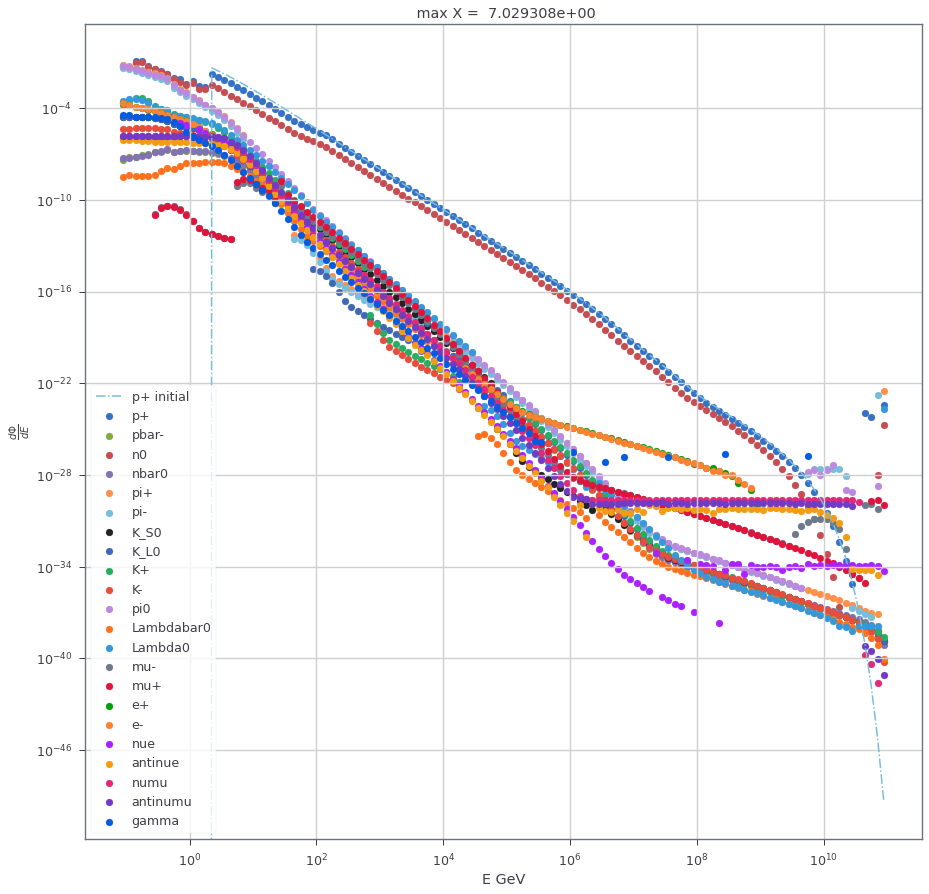

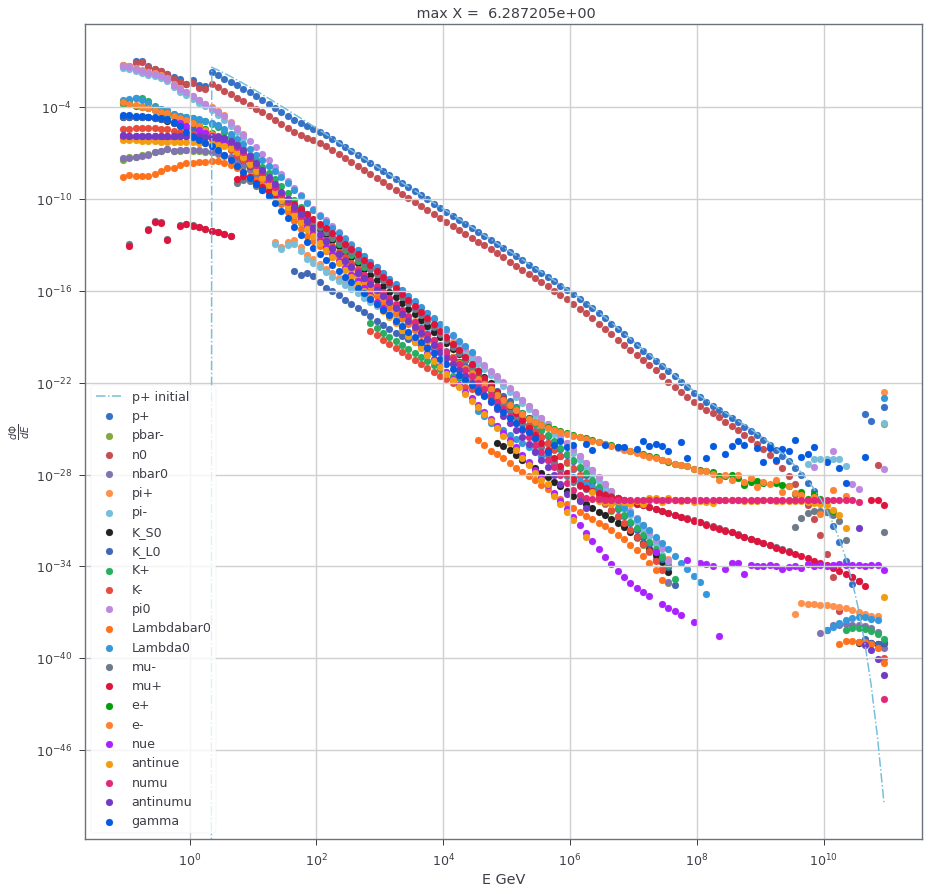

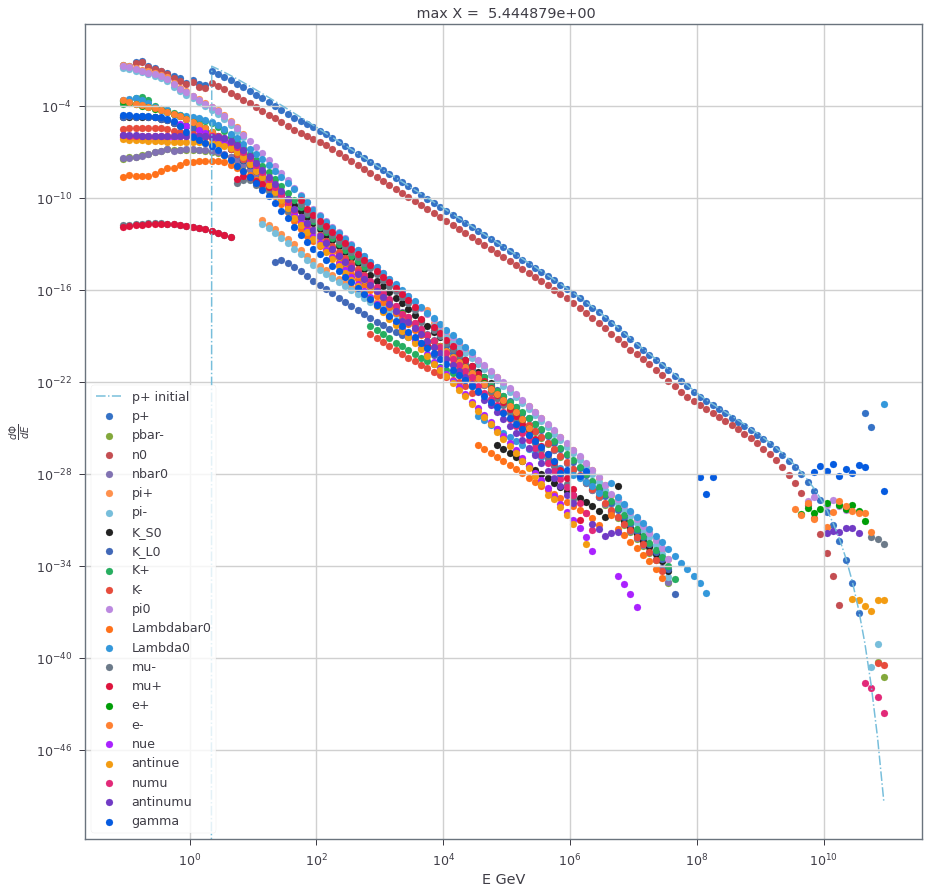

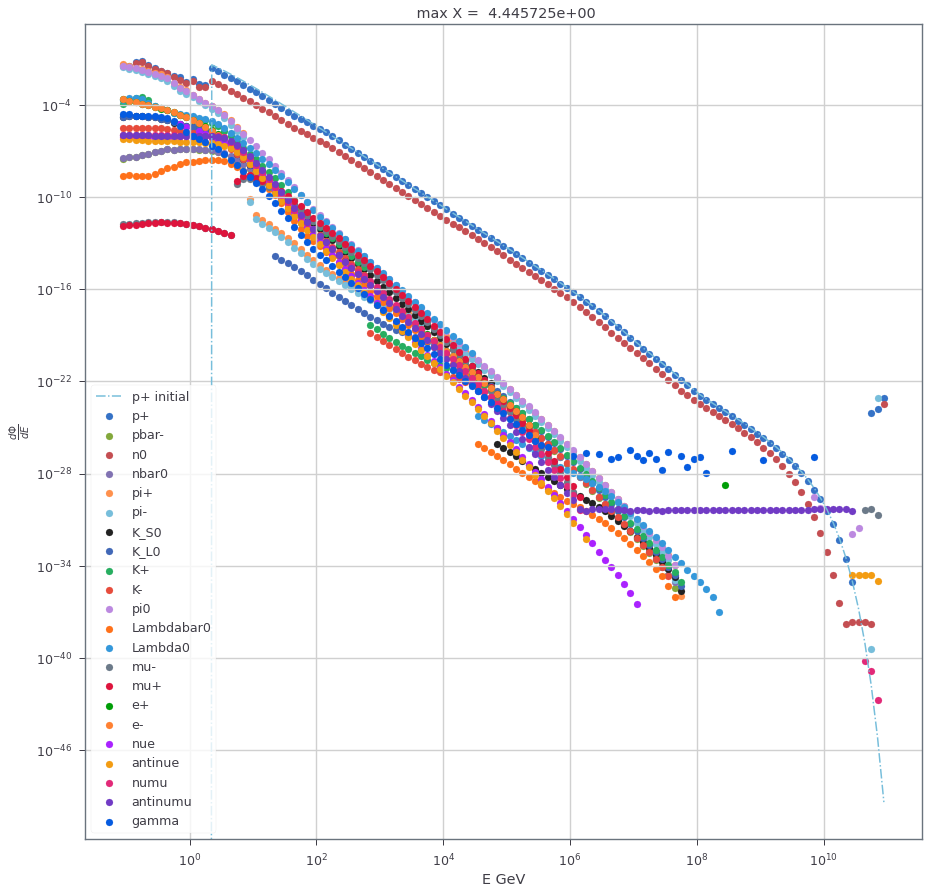

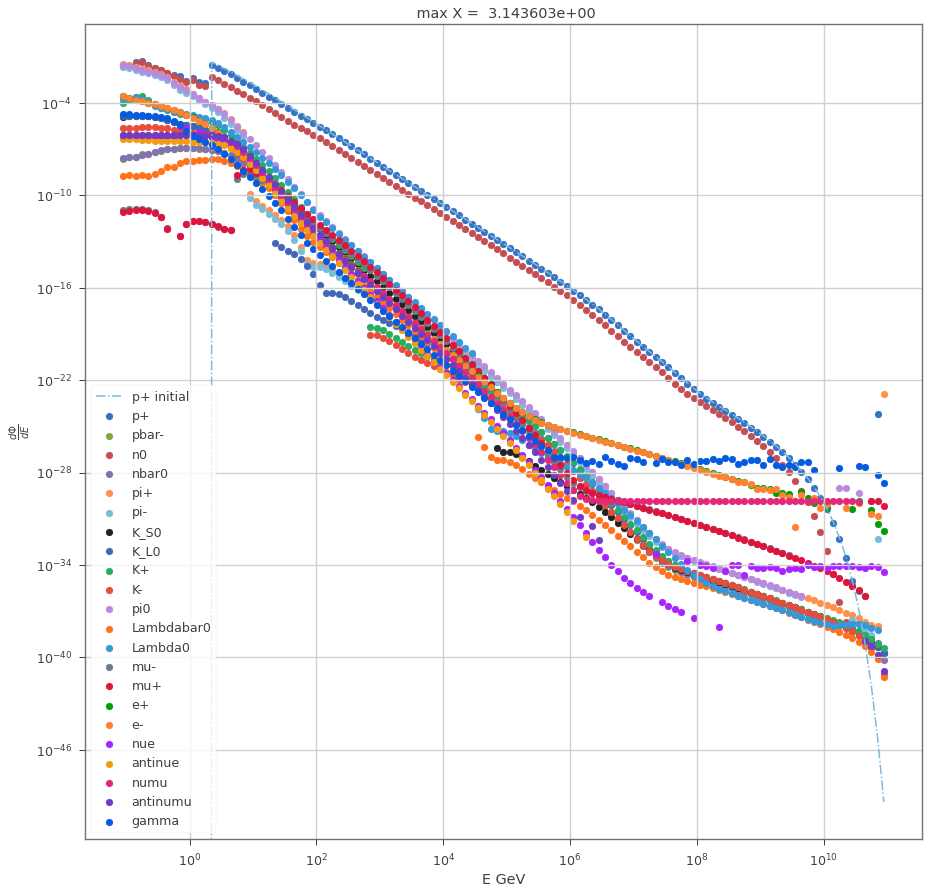

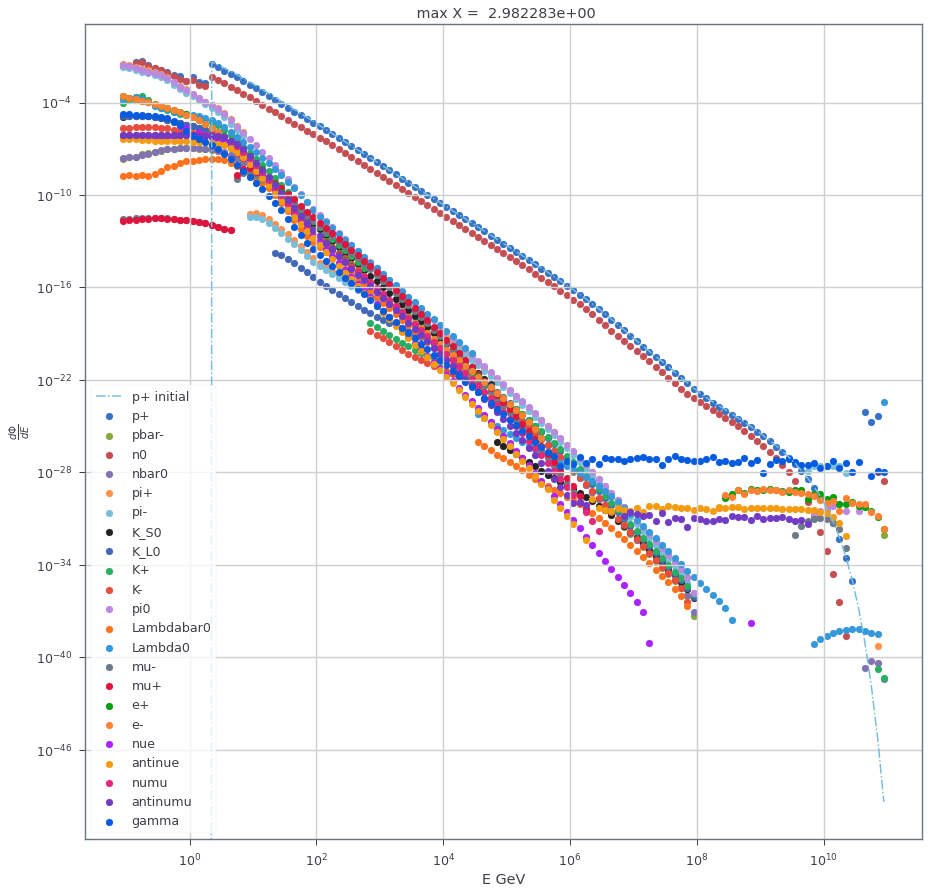

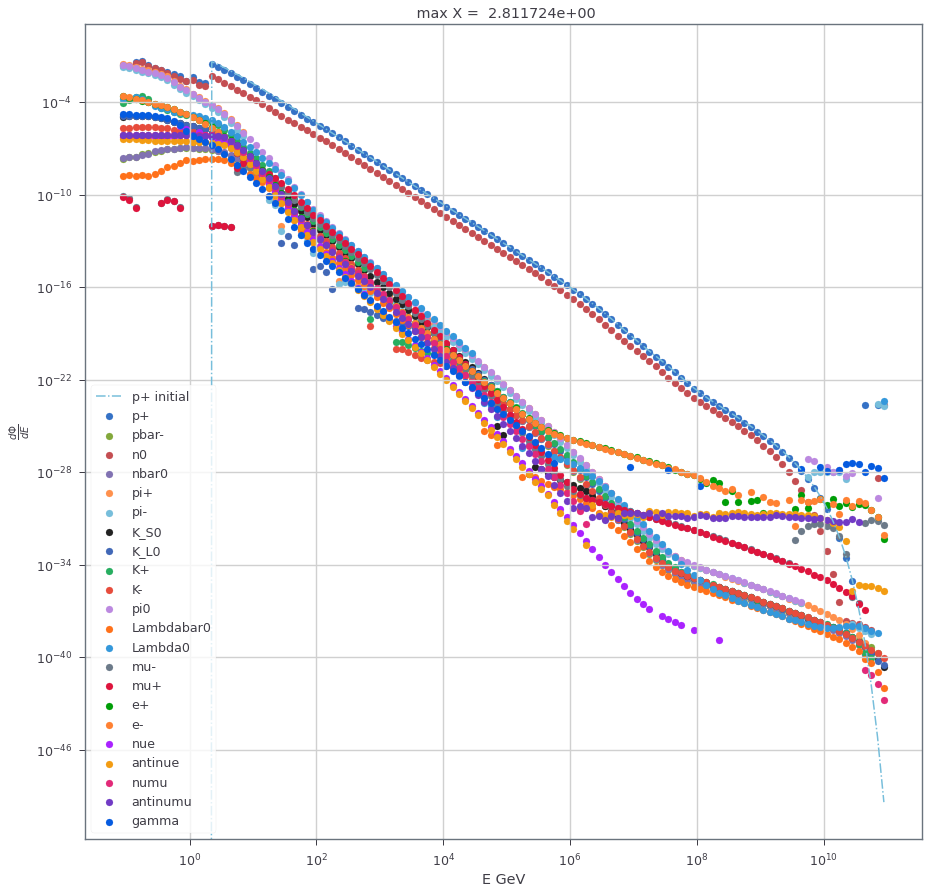

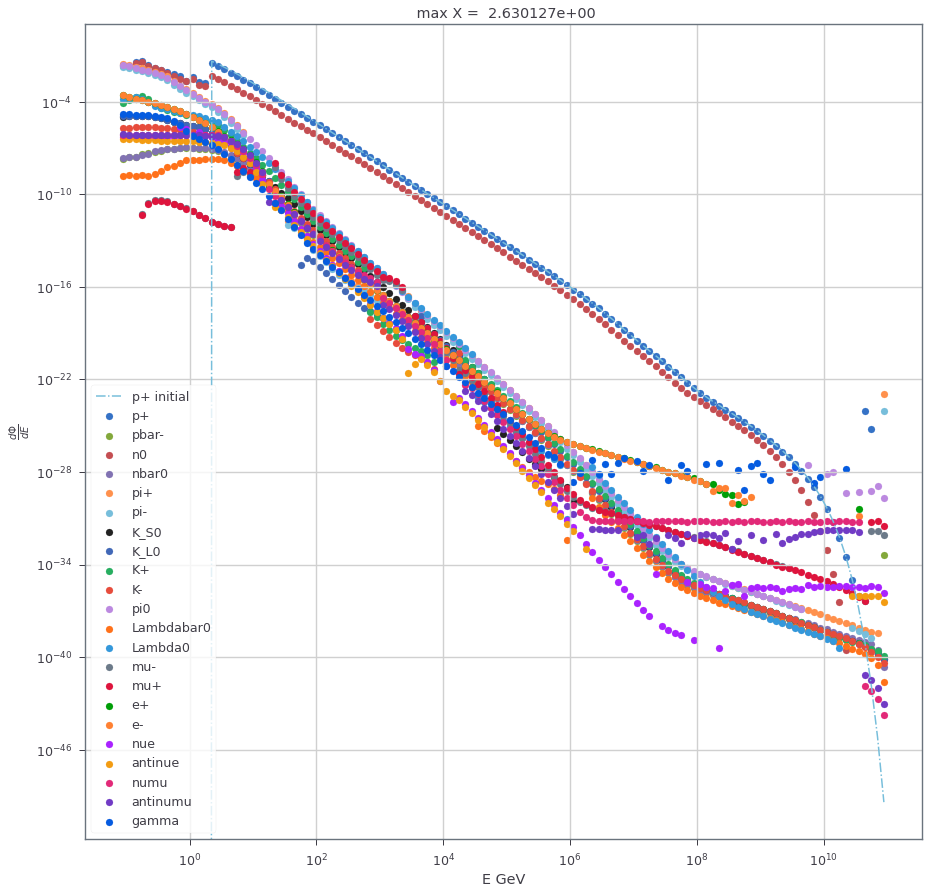

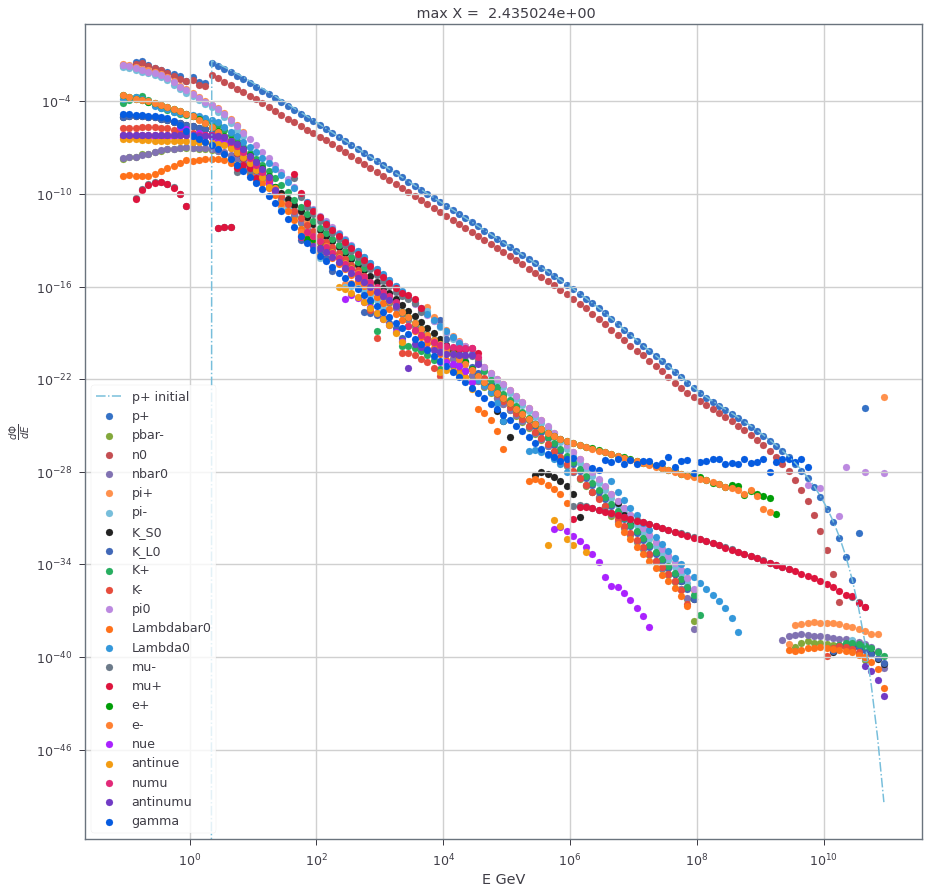

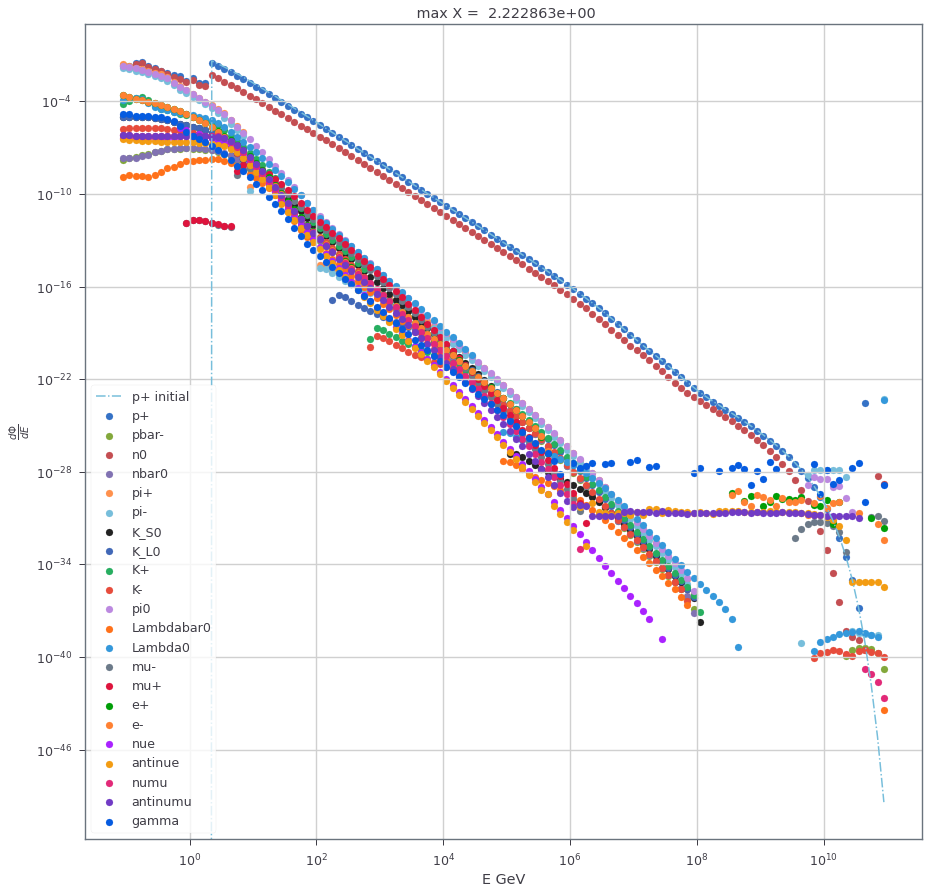

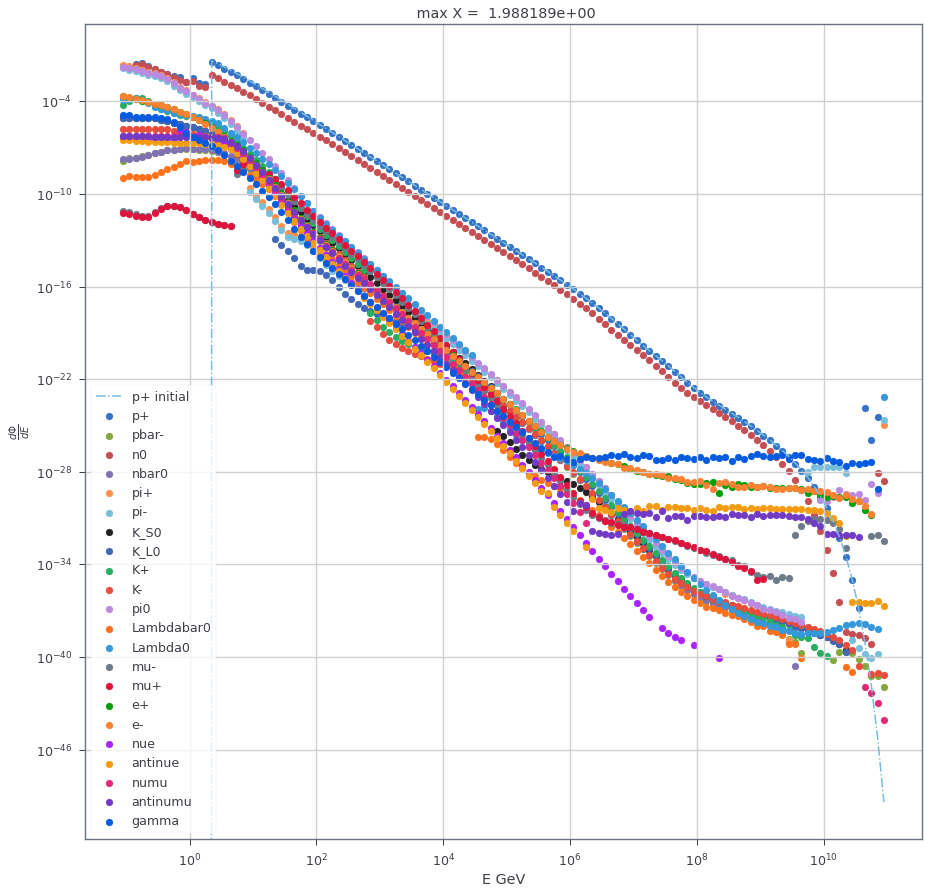

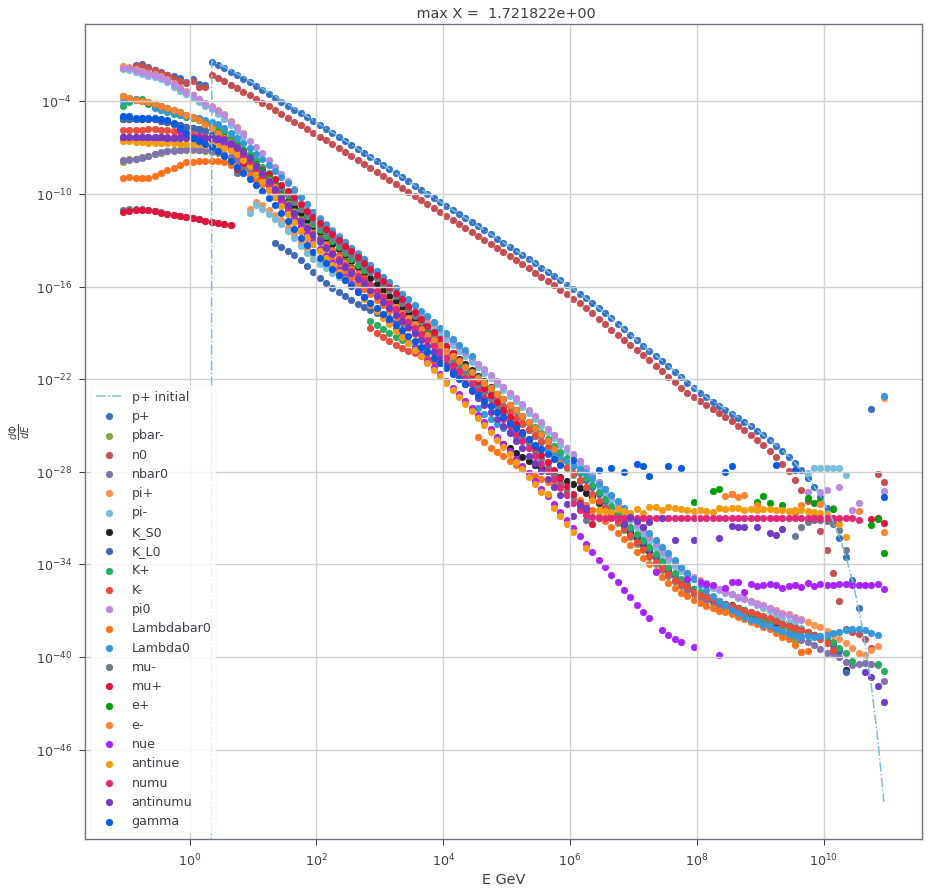

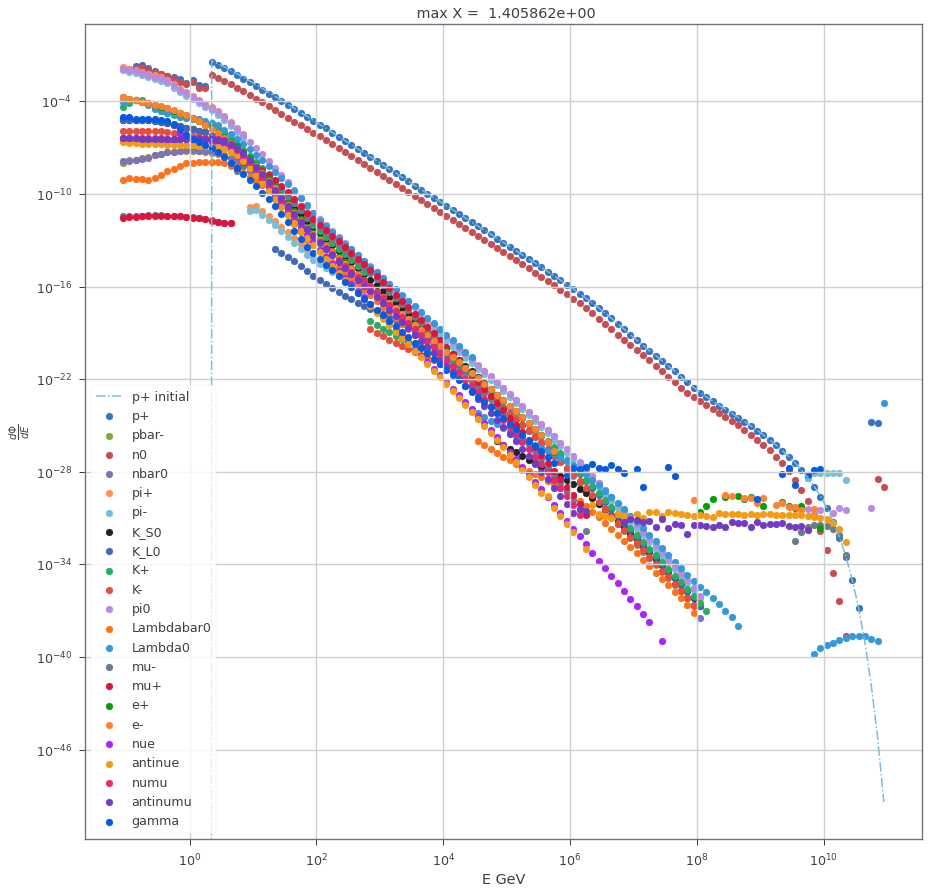

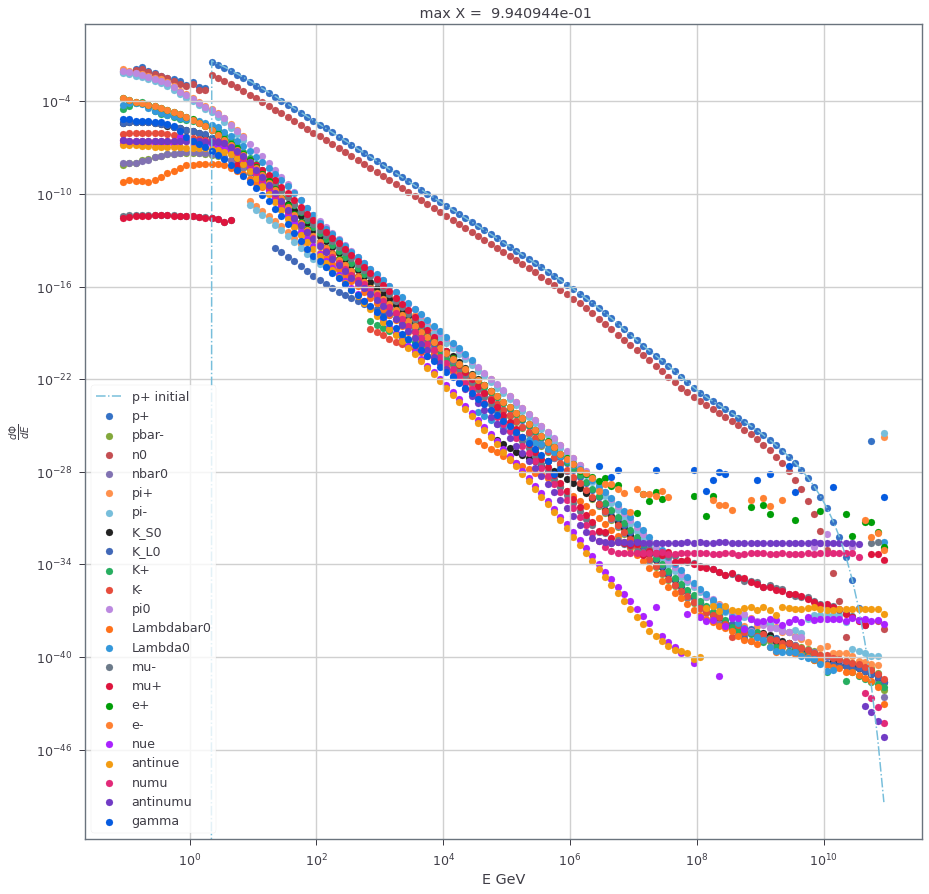

In [16]:
for i,h in enumerate(h_list):
    plt.figure(figsize=(15,15))
    for j,p in enumerate(list_particles):
        bb_1=(r[h_list[i]*R_sun])
         
       # bb_2=np.transpose(sol_ivp_csr[h_list[i+1]*R_sun]['y'])
        #phi_ratio=bb_1[-1][ind[p.name,'up']:ind[p.name,'low']]/ bb_2[-1][ind[p.name,'up']:ind[p.name,'low']]
        rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])
        
        #rr=rr*(mceq_run.e_grid**3)
        plt.scatter(mceq_run.e_grid,rr,label=p.name)
    #print(np.sum(rr*mceq_run.e_widths,axis=0))
    #phi_t.append(abs(np.sum(rr*mceq_run.e_widths,axis=0)))   

#plt.scatter(h_list[::-1],
                 #phi_t[::-1],label=p.name)
        
    plt.plot(mceq_run.e_grid,phi[ind["p+","up"]:ind["p+","low"]],"c-.",label="p+ initial ")

    plt.title(r" max X =  "+ '{:e}'.format(X[new_h[i]][-1]))
    plt.xlabel("E GeV")
    plt.ylabel(r'$\frac{d\Phi}{dE}$')
        #plt.ylim((1e-85,1e3))
        #plt.xlim((1e1,1e7))
    plt.legend()
    plt.grid()
    plt.xscale("log")
    plt.yscale("log")
    plt.savefig('/home/kruteesh/Desktop/Solar_neutrinos/diffsec/pics/16,01,21/'+str(h_list[i])+'.png')


# In[48]:




6.607137435858864e-06 0.9999995
6.150861046501764e-06 0.9999996
5.568017609659917e-06 0.9999997
4.794211566536107e-06 0.9999998
3.638343146745155e-06 0.9999999
3.4804428920844686e-06 0.99999991
3.305003545542581e-06 0.9999999200000002
3.143011291961201e-06 0.9999999300000001
2.9555822918720246e-06 0.99999994
2.6877490586537485e-06 0.99999995
2.4269912367338856e-06 0.9999999599999999
2.1286765706234696e-06 0.99999997
1.7617854795566698e-06 0.9999999800000001
1.2523911158192271e-06 0.9999999900000001


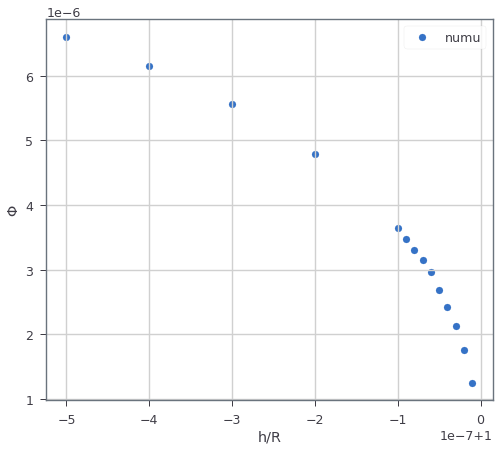

In [17]:
import matplotlib.pyplot as plt
import numpy as np
phi_t=[]
p=mceq_run.pman[14]
for h in new_h:
    bb_1=(r[h])
    rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])
    print(np.sum(rr*mceq_run.e_widths),h/R_sun)
    phi_t.append(abs(np.sum(rr*mceq_run.e_widths)))

fig, ax = plt.subplots()
hh=h_list[::-1]
ax.scatter(h_list,phi_t,label=p.name)
#ax.set_xlim(5, 0)  # decreasing time
#ax.set_yscale("log")
ax.set_xlabel("h/R")
ax.set_ylabel(r"$\Phi$")
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
h_list[::-1]

In [ ]:
plt.plot(r_ratio,rho_data)
plt.xlabel("R/R_sun")
plt.ylabel(r"$\rho_{sun}$   g/$cm^3$")
#plt.ylim((140,160))
#plt.xlim((-0.005,0.02))